# GAMA Analysis

In [1]:
#SET UP

import itertools

#Graphing
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10,10)

#Tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# These lines make warnings look nicer
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Useful for probability calculations
from scipy import stats
from scipy import special

#Regression Packages
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from IPython.core.display import HTML
from statsmodels.sandbox.regression.gmm import IV2SLS

Let's begin by loading our data and creating some DateTime columns

In [2]:
gama = pd.read_csv("gama_statewide_dw_pb_combined_2020-04-27.csv")
gama['date'] = pd.to_datetime(gama['date'])
gama['year'] = pd.DatetimeIndex(gama['date']).year
gama['month'] = pd.DatetimeIndex(gama['date']).month
gama.head()

,well_id,results,chemical,date,units,qualifer,rl,latitude,longitude,well_type,well_depth_ft,top_of_screen_ft,screen_length_ft,source,source_name,other_names,year,month
0,ED 441,69.00,ALK,2003-04-22,MG/L,=,NaN,38.729598,-120.716085,DOMESTIC,NaN,NaN,NaN,GAMA,ED 441,VERDE ROBLES COURT,2003,4
1,ED 441,1.13,ALPHA,2003-04-22,pCi/L,=,NaN,38.729598,-120.716085,DOMESTIC,NaN,NaN,NaN,GAMA,ED 441,VERDE ROBLES COURT,2003,4
2,ED 441,1.00,BDCME,2003-04-22,UG/L,<,NaN,38.729598,-120.716085,DOMESTIC,NaN,NaN,NaN,GAMA,ED 441,VERDE ROBLES COURT,2003,4
3,ED 441,14.00,CA,2003-04-22,MG/L,=,NaN,38.729598,-120.716085,DOMESTIC,NaN,NaN,NaN,GAMA,ED 441,VERDE ROBLES COURT,2003,4
4,ED 441,1.00,CLBZ,2003-04-22,UG/L,<,NaN,38.729598,-120.716085,DOMESTIC,NaN,NaN,NaN,GAMA,ED 441,VERDE ROBLES COURT,2003,4


## EDA


In [15]:
gama['source'].value_counts()

USGS    450263
GAMA    102486
Name: source, dtype: int64

In [4]:
translation = pd.DataFrame(index = [1,2,3,4,5,6,7,8,9,10], columns = ["Acronym", "Name/Description", "Primary Uses"])


translation["Acronym"] = ["24D", "ACE", "ALDICARB", "ALDSULF",
                        "17DIMETHLYX", "ACETAMPHEN","ALBUTEROL", 
                          "ALACL", "AL","AG"]

translation["Name/Description"] = ["2,4-Dichlorophenoxyacetic acid",
                                  "Artificial Sweetener Acesulfame",
                                  "Aldicarb ",
                                   "Aldicarb Sulfone",
                                   "-",
                                   "Acetaminophen",
                                   "-",
                                   "Aluminim Chloride",
                                   "Aluminum",
                                   "Silver"]

translation["Primary Uses"] = ["Herbicide",
                               "Hypertension Medication",
                               "Pesticide","Pesticide",
                               "Bladder Inflamation Medication",
                               "Fever Control",
                               "Asthma Medication",
                               "Common Deodarant Material",
                               "Various",
                               "Various"]

translation


,Acronym,Name/Description,Primary Uses
1,24D,"2,4-Dichlorophenoxyacetic acid",Herbicide
2,ACE,Artificial Sweetener Acesulfame,Hypertension Medication
3,ALDICARB,Aldicarb,Pesticide
4,ALDSULF,Aldicarb Sulfone,Pesticide
5,17DIMETHLYX,-,Bladder Inflamation Medication
6,ACETAMPHEN,Acetaminophen,Fever Control
7,ALBUTEROL,-,Asthma Medication
8,ALACL,Aluminim Chloride,Common Deodarant Material
9,AL,Aluminum,Various
10,AG,Silver,Various


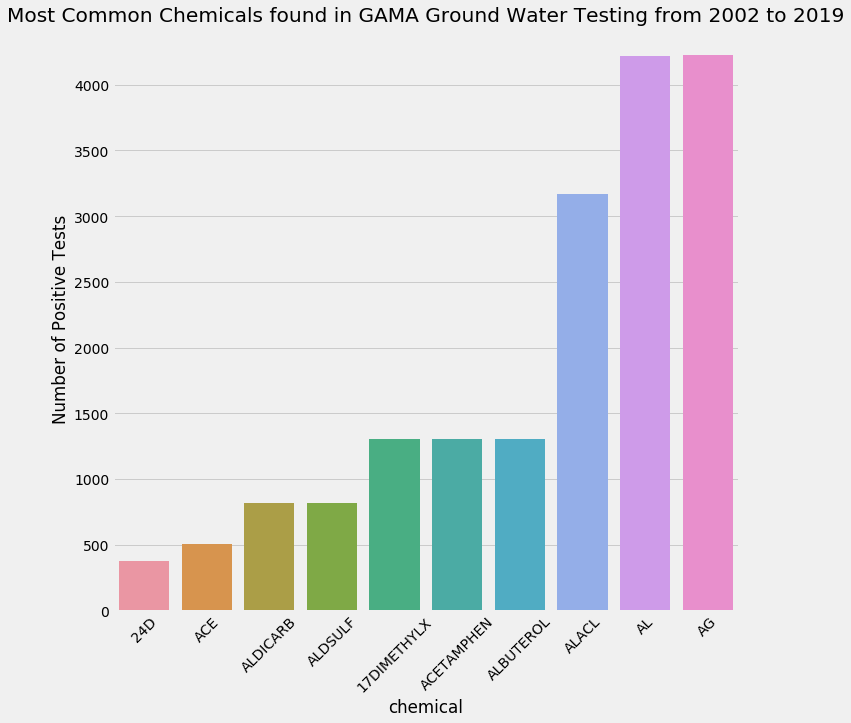

In [5]:
top10 = gama.groupby('chemical').agg('count').iloc[0:10, :].sort_values('well_id')
top10.reset_index(inplace=True)
bar = sns.barplot(x='chemical', y='well_id', data = top10)
bar.set_xticklabels(bar.get_xticklabels(), rotation=45)
plt.ylabel("Number of Positive Tests")
plt.title("Most Common Chemicals found in GAMA Ground Water Testing from 2002 to 2019");

Overall the top 10 seem to be the most interesting of the 200 chemicals to observe because the probability of observing the most common chemical is already less than 1% (4000/500000).

In [6]:
top10_chemicals = top10['chemical']
top10_chemicals = [i for i in top10_chemicals]

top10 = gama[gama['chemical'].isin(top10_chemicals)]
top10.head()
# top10.to_csv(r"top10.csv")

,well_id,results,chemical,date,units,qualifer,rl,latitude,longitude,well_type,well_depth_ft,top_of_screen_ft,screen_length_ft,source,source_name,other_names,year,month
124,ED 447,570.0,AL,2003-04-23,UG/L,=,NaN,38.790512,-120.880604,DOMESTIC,NaN,NaN,NaN,GAMA,ED 447,JOHNSON RANCH ROAD,2003,4
179,ED 326,1.0,AG,2003-02-14,UG/L,<,NaN,38.697475,-120.775215,DOMESTIC,NaN,NaN,NaN,GAMA,ED 326,WASHBOARD LANE,2003,2
202,ED 361,1.0,AG,2003-03-06,UG/L,<,NaN,38.578619,-120.978612,DOMESTIC,NaN,NaN,NaN,GAMA,ED 361,SWIFT ROAD,2003,3
261,ED 514,1.0,AL,2004-04-13,UG/L,<,NaN,38.623937,-120.746598,DOMESTIC,NaN,NaN,NaN,GAMA,ED 514,ELDERBERRY,2004,4
271,ED 519,1.0,AL,2004-04-12,UG/L,<,NaN,38.676229,-120.815115,DOMESTIC,NaN,NaN,NaN,GAMA,ED 519,FOWLER LANE,2004,4


Let's look into trichloroethylene or TCE, because the article 

(https://www.kqed.org/futureofyou/388730/silicon-valleys-toxic-past-haunts-sunnyvale-neighborhood) states how superfunds in Santa Clara used it to clean microchips, a popular export of the Silicon Valley

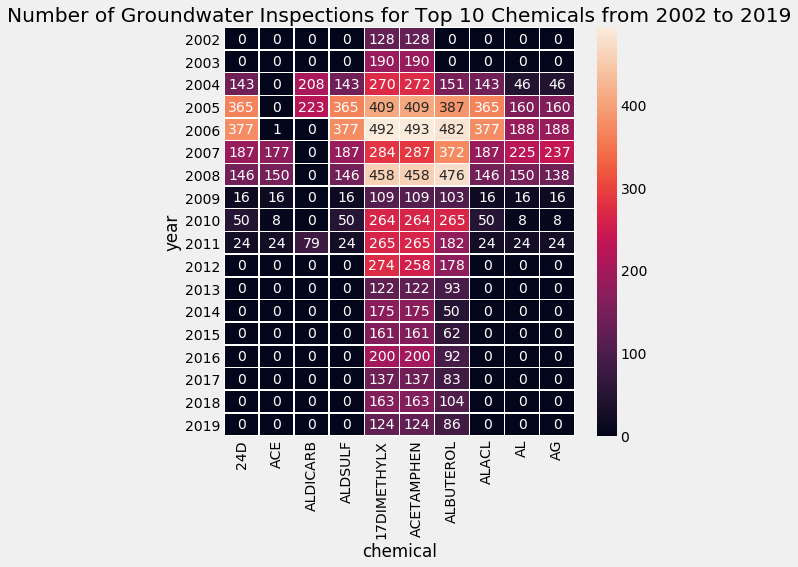

In [7]:
pivot = top10.pivot_table(index='year', columns='chemical', 
                          values='results', aggfunc = 'count').fillna(0).astype(int)


plt.subplots(figsize=(7, 7))
heatmap = sns.heatmap(pivot, annot=True, fmt="d",  linewidths=.5)
heatmap.set_xticklabels(bar.get_xticklabels())
plt.title("Number of Groundwater Inspections for Top 10 Chemicals from 2002 to 2019");

# TCE


In [8]:
tce = gama[gama['chemical'] == "TCE"]
tce.head()

,well_id,results,chemical,date,units,qualifer,rl,latitude,longitude,well_type,well_depth_ft,top_of_screen_ft,screen_length_ft,source,source_name,other_names,year,month
68,ED 450,1.0,TCE,2003-04-24,UG/L,<,NaN,38.729488,-120.714474,DOMESTIC,NaN,NaN,NaN,GAMA,ED 450,VERDE ROBLES,2003,4
162,ED 659,1.0,TCE,2004-05-24,UG/L,<,NaN,38.690327,-120.658374,DOMESTIC,NaN,NaN,NaN,GAMA,ED 659,ALAMEDA ROAD,2004,5
177,ED 699,1.0,TCE,2004-06-16,UG/L,<,NaN,38.500739,-121.136566,DOMESTIC,NaN,NaN,NaN,GAMA,ED 699,Bisbee Drive,2004,6
193,ED 326,1.0,TCE,2003-02-14,UG/L,<,NaN,38.697475,-120.775215,DOMESTIC,NaN,NaN,NaN,GAMA,ED 326,WASHBOARD LANE,2003,2
239,ED 463,1.0,TCE,2003-05-08,UG/L,<,NaN,38.805900,-120.932932,DOMESTIC,NaN,NaN,NaN,GAMA,ED 463,GODS WAY,2003,5


In [9]:
# tce.to_csv(r"tce.csv")